In [1]:
using CSV
using DataFrames
using Statistics
using Random
# using Plots
using PlotlyJS

In [2]:
csv = CSV.File(joinpath("data", "Ship game.csv"); header=1, skipto=4, delim=";", select=1:4);

In [3]:
const RADIUS_DAMAGE = 10
const NUM_TARGETS = 2
const N_ROLLS = 10;

In [4]:
df = DataFrame(csv)
df = rename(df, ["ship", "x", "y", "z"])

Row,ship,x,y,z
,String7,Int64,Int64,Int64
1,CSM_1,200,150,150
2,CSM_2,210,130,140
3,CSM_3,205,120,135
4,CSM_4,205,130,135
5,CSM_5,205,50,50
6,CSM_6,205,65,50
7,CSM_7,210,50,70
8,CSM_8,200,30,50
9,CSM_9,100,45,50


In [5]:
coords = Matrix(df[:, 2:end])

10×3 Matrix{Int64}:
 200  150  150
 210  130  140
 205  120  135
 205  130  135
 205   50   50
 205   65   50
 210   50   70
 200   30   50
 100   45   50
  45  100   92

In [6]:
function distance_to_edges(coords, edge_val)
    diff_edge = coords .- edge_val
    euclidean_dist = sqrt.(vec(sum(diff_edge .^ 2, dims=2)))
    euclidean_dist
end

distance_to_edges (generic function with 1 method)

In [7]:
function closest_edge(coords, edge_val, indices)
    closest_distance = Inf
    closest_edge = 0
    for i in indices
        euclidean_dist = sqrt(sum((coords[i, :] .- edge_val) .^ 2))
        # println(coords[i, :], " ", edge_val, " ", euclidean_dist)
        if euclidean_dist < closest_distance
            # println(closest_distance, ' ', euclidean_dist)
            closest_distance = euclidean_dist
            closest_edge = i
        end
    end
    if closest_edge == 0
        error("no available indices")
    end
    closest_edge, closest_distance
end

function closest_edge(coords, edge)
    euclidean_dist = distance_to_edges(coords, edge)
    euclidean_dist[edge] = Inf
    argmin(euclidean_dist)
end
;

In [8]:
coords

10×3 Matrix{Int64}:
 200  150  150
 210  130  140
 205  120  135
 205  130  135
 205   50   50
 205   65   50
 210   50   70
 200   30   50
 100   45   50
  45  100   92

In [9]:
function find_centroid(coords::Array{Int64,2})
    mean(coords, dims=1)
end

find_centroid (generic function with 1 method)

In [10]:
function pop_rand!(s::Set)
    pop!(s, rand(s))
end

pop_rand! (generic function with 1 method)

## Score best clustering

In [11]:
function score_cluster(coords, cluster)
    "First is number of member, second - mean distance to members from the center"
    center = find_centroid(coords[cluster, :])
    distances_to_members = distance_to_edges(coords[cluster, :], center)
    length(cluster), -sum(distances_to_members)
end

score_cluster (generic function with 1 method)

In [12]:
function sort_clusters(clusters)
    sorted_dict = sort(collect(clusters), by=x -> score_cluster(coords, x[2]), rev=true)
    return [v for (n, (k, v)) in enumerate(sorted_dict)]
end

sort_clusters (generic function with 1 method)

In [13]:
function score_clustering(coords, clusters)
    best_clusters = sort_clusters(clusters)[begin:NUM_TARGETS]
    scores_matrix = reduce(vcat, transpose.(map(x -> collect(score_cluster(coords, x)), best_clusters)))
    Tuple(sum(scores_matrix, dims=1))
end

score_clustering (generic function with 1 method)

## Find clusters

In [14]:
function find_clusters_greedy(coords, threshold)
    clusters = Dict{Int64,Vector{Int64}}()
    available_edges = Set([1:size(coords)[1];])
    current_cluster = 1
    clusters[current_cluster] = [pop_rand!(available_edges)]
    while !isempty(available_edges)
        cluster_center = find_centroid(coords[clusters[current_cluster], :])
        cl_edge_idx, cl_distance = closest_edge(coords, vec(cluster_center), available_edges)
        to_be_cluster = coords[vcat(clusters[current_cluster], [cl_edge_idx]), :]

        new_cluster_center = find_centroid(to_be_cluster)

        all_distances = distance_to_edges(to_be_cluster, new_cluster_center)

        if cl_distance > threshold || any(x -> x > threshold, all_distances)
            current_cluster += 1
            clusters[current_cluster] = [pop_rand!(available_edges)]
        else
            delete!(available_edges, cl_edge_idx)
            push!(clusters[current_cluster], cl_edge_idx)
        end
    end
    clusters
end

function find_clusters(coords, threshold)
    best_clustering = Dict()
    best_quality = (-Inf, -Inf)
    for _ in 1:N_ROLLS
        clusters = find_clusters_greedy(coords, threshold)
        quality = score_clustering(coords, clusters)
        # println(typeof(quality), quality, typeof(best_clustering), best_clustering)
        if quality > best_quality
            best_clustering = clusters
            best_quality = quality
        end
    end
    sort_clusters(best_clustering)
end


find_clusters (generic function with 1 method)

In [15]:
clusters = find_clusters_greedy(coords, 20)

Dict{Int64, Vector{Int64}} with 7 entries:
  5 => [8]
  4 => [9]
  6 => [1]
  7 => [10]
  2 => [7]
  3 => [4, 2, 3]
  1 => [5, 6]

In [16]:
find_clusters(coords, 20)

7-element Vector{Vector{Int64}}:
 [3, 4, 2]
 [5, 6]
 [10]
 [9]
 [8]
 [7]
 [1]

## Plots

In [17]:
# plt = plot3d(
#     1,
#     xlim = (-30, 30),
#     ylim = (-30, 30),
#     zlim = (0, 60),
#     title = "Lorenz Attractor",
#     legend = false,
#     marker = 2,
# )
scatter(coords[:, 1], coords[:, 2], coords[:, 3])

MethodError: MethodError: no method matching scatter(::Vector{Int64}, ::Vector{Int64}, ::Vector{Int64})

In [18]:
coords

10×3 Matrix{Int64}:
 200  150  150
 210  130  140
 205  120  135
 205  130  135
 205   50   50
 205   65   50
 210   50   70
 200   30   50
 100   45   50
  45  100   92

In [19]:
targets = find_clusters(coords, RADIUS_DAMAGE)[begin:NUM_TARGETS]
m = reduce(vcat, map(x -> find_centroid(coords[x, :]), targets))
centers_targets = DataFrame(m, [:x, :y, :z])

Row,x,y,z
,Float64,Float64,Float64
1,206.667,126.667,136.667
2,205.0,65.0,50.0


In [20]:
targeted = Set(reduce(vcat, targets))

Set{Int64} with 4 elements:
  4
  6
  2
  3

In [21]:
is_targeted = [i in targeted ? "red" : "blue" for i in 1:size(df)[1]]

10-element Vector{String}:
 "blue"
 "red"
 "red"
 "red"
 "blue"
 "red"
 "blue"
 "blue"
 "blue"
 "blue"

In [22]:
df[!, :is_targeted] = is_targeted

10-element Vector{String}:
 "blue"
 "red"
 "red"
 "red"
 "blue"
 "red"
 "blue"
 "blue"
 "blue"
 "blue"

┌ Warning: attempting to remove probably stale pidfile
│   path = /Users/pyro/.jlassetregistry.lock
└ @ Pidfile /Users/pyro/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


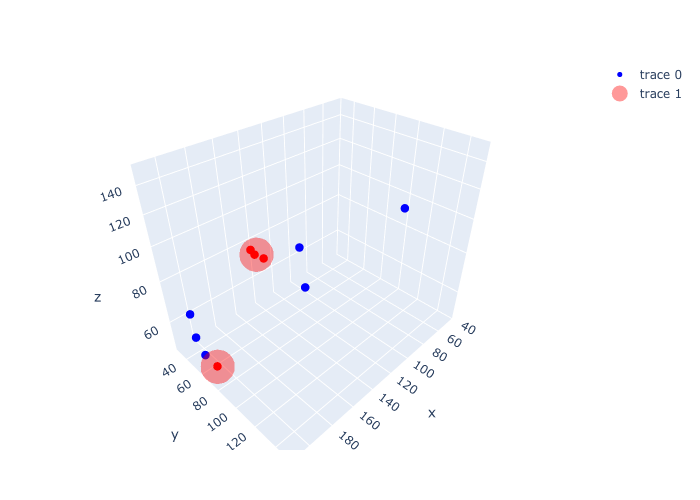

In [23]:
trace_dots = scatter3d(
    df,
    x=:x,
    y=:y,
    z=:z,
    mode="markers",
    marker=attr(
        size=:5,
        color=:is_targeted,
        sizemode="diameter"
    )
)
trace_bubble = scatter3d(
    centers_targets,
    x=:x,
    y=:y,
    z=:z,
    mode="markers",
    marker=attr(
        size=RADIUS_DAMAGE * 2,
        sizeref=750,
        color="red",
        sizemode="diameter",
        opacity=0.4,
    )
)

layout = Layout(scene_zaxis_type="log")
plot([trace_dots, trace_bubble], layout)